In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!git clone https://github.com/Mahsarnzh/XAI_Nuc.git

Cloning into 'XAI_Nuc'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 188 (delta 45), reused 106 (delta 44), pack-reused 79
Receiving objects: 100% (188/188), 10.30 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.9 MB/s eta 0:00:00


In [3]:
import sys
import os
sys.path.append("/content/XAI_Nuc/")

In [4]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
%cd /content/XAI_Nuc

/content/XAI_Nuc


In [6]:
import criticNet.model
import actorNet.model

In [7]:
import criticNet_env.model
import actorNet_env.model

In [8]:
model_actorNet = actorNet.load_model(os.path.join(os.path.dirname(actorNet.__file__), "weights.h5"))
model_criticNet = criticNet.load_model(os.path.join(os.path.dirname(criticNet.__file__), "weights.h5"))

In [9]:
model_actorNet_env = actorNet_env.load_model(os.path.join(os.path.dirname(actorNet_env.__file__), "weights.h5"))
model_criticNet_env = criticNet_env.load_model(os.path.join(os.path.dirname(criticNet_env.__file__), "weights.h5"))

In [10]:
! pip install onnx_tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 33.2 MB/s eta 0:00:00


In [11]:
import onnx

from onnx_tf.backend import prepare

actorNet_onnx_model = onnx.load("actorNet.onnx")  # load onnx model
tf_rep = prepare(actorNet_onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [12]:
import tensorflow as tf
import numpy as np

# Load the ONNX model
actorNet_onnx = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)

In [13]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [14]:
# %cd /content

In [15]:
# import onnxruntime as ort

# actorNet_onnx_model = ort.InferenceSession('pretrainedAgen.onnx')


In [16]:
# actorNet_onnx_model.get_outputs()[0].name

In [17]:
# input_name = actorNet_onnx_model.get_inputs()[0].name
# output = actorNet_onnx_model.run(None, [{'data': input_data}])


In [18]:
import numpy as np
import gym
from gym import spaces
import itertools
from gym.spaces import Box

class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1

        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        # self.State = np.zeros((5, 1))
        self.IsDone = 0

    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]
        # print(OrderPart1, MaintDecision1)

        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]

        Month += 1
        PartReplaced1 = 0

        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            # print(np.random.gamma(self.InitialHealthNoise))
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            # print(np.random.gamma(self.InitialHealthNoise))
            PartReplaced1 = 1

            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth
                # print(Component1)

        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap
            # print(Component1)



        if Month%(self.RefuelPeriod) != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)

        # Component1 = max(Component1, 0)  # Health can not be less than 0

        if Component1 == 0:
            Sensor1 = 0  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            elif Sensor1 < 0:
              Sensor1 = max(Sensor1,-0.11)
            Sensor1 = max(min(Sensor1, 1), -0.11)

        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month%(self.RefuelPeriod)) / self.RefuelPeriod

        # data = np.array(ArrivalDate1)
        # updated_data = np.array([data[0][0] - 1])
                  # ArrivalDate1 -= 1
        ArrivalDate1 = [x - 1 for x in ArrivalDate1]

        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog



        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)

        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0

        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)
        # self.State = tf.convert_to_tensor(State, dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        # observation = tf.reshape(Observation, (1, -1))

        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}

    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1

        if Month%(self.RefuelPeriod) == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - (Month%self.RefuelPeriod)) / self.RefuelPeriod

        # Sensor1 = -0.6
        # DaysToShutdown = -30
        # InvNorm1 = 1.5

        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)
        # print(Sensor1)
        # self.State = tf.convert_to_tensor(State, dtype=tf.float32)
        return initial_observation

    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]

        Action1 = Action[0]
        OrderPart1 = Action[1]

        reward = 0

        if Inv1 > 0:
            reward += self.CostInventory * Inv1

        reward += self.CostToOrder * OrderPart1

        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity

        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace

        return reward


In [19]:
# import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 500

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


# actorNet_onnx = onnx.load("actorNet.onnx")

# Prepare the ONNX model for TensorFlow
# actorNet_onnx_model = prepare(actorNet_onnx)



actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)

        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32)
        state_tensors.append(input_data)

        # state_tensors.append(state_tensor_)

        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)


        # action_probs = actor(state_tensor_)

        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        action_index = action_log_prob.numpy().item()

        # action_log_prob = torch.argmax(action_logits)
        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action

        action = actionelements[action_index]

        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break


    # print("Episode {}: Reward = {}".format(episode, episode_reward))
    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    # rewards = tf.squeeze(episode_rewards)
    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode
# self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [20]:
action_log_.shape

(500, 2)

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


<Figure size 640x480 with 0 Axes>

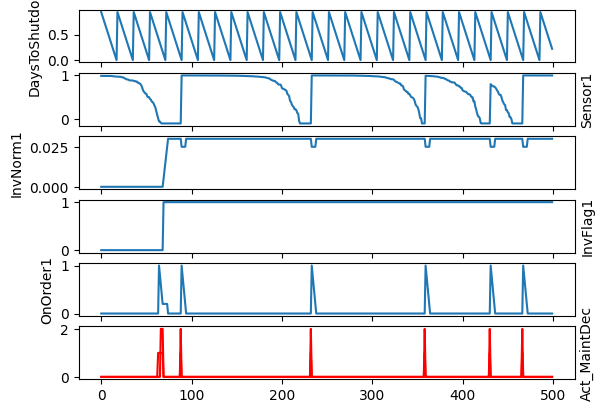

In [21]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0,0]), plt.ylabel('DaysToShutdown')

plt.subplot(612), plt.plot(state_log[:,0,1]), plt.ylabel('Sensor1')
plt.subplot(612).yaxis.set_label_position('right')

plt.subplot(613), plt.plot(state_log[:,0,2]), plt.ylabel('InvNorm1')

plt.subplot(614), plt.plot(state_log[:,0,3]), plt.ylabel('InvFlag1')
plt.subplot(614).yaxis.set_label_position('right')

plt.subplot(615), plt.plot(state_log[:,0,4]), plt.ylabel('OnOrder1')

plt.subplot(616), plt.plot(action_log, 'r'), plt.ylabel('Act_MaintDec')
plt.subplot(616).yaxis.set_label_position('right')

# plt.subplot(616), plt.plot(action_log[:,0], 'r'), plt.ylabel('Ac(0)_MaintDec')
# plt.subplot(616), plt.plot(action_log[:,1], 'r'), plt.ylabel('Act(1)_OrderPart')




In [22]:
def model_predict(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)

    return outputs[0]

In [23]:
def model_predict_Max(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)
    max_values = np.max(outputs[0], axis=-1)
    return max_values


In [24]:
# Define the names of the states
feature_names=['DaysToShutdown', 'Sensor1', 'InvNorm1', 'InvFlag1', 'OnOrder1']

In [25]:
def model_predict(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)

    return outputs[0]

In [26]:
for t in range(max_steps_per_episode):

    state_tensor = tf.convert_to_tensor(state)
    state_tensor_ = tf.expand_dims(state_tensor, 0)

    input_data = tf.cast(state_tensor_, dtype=tf.float32)
    # Create input tensor
    input_data = tf.constant(input_data, dtype=tf.float32)
    state_tensors.append(input_data)

    # state_tensors.append(state_tensor_)

    # Get action probabilities from actor network
    action_probs = actorNet_onnx_model.run(input_data)


    # action_probs = actor(state_tensor_)

    # Sample an action from the action probabilities
    action_log_prob = tf.argmax(action_probs, axis=-1)
    action_index = action_log_prob.numpy().item()

    # action_log_prob = torch.argmax(action_logits)
    actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


    # Retrieve the corresponding action

    action = actionelements[action_index]

In [27]:
# state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
# explainer__Max = shap.KernelExplainer(model_predict_Max, state_log_reshaped)
# shap_values__Max = explainer__Max.shap_values(state_log_reshaped)

In [28]:
# shap.summary_plot(shap_values__Max, state_log_reshaped, feature_names=feature_names, color_bar_label = 'nevermind')

In [29]:
# state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
# explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
# shap_values = explainer.shap_values(state_log_reshaped)

In [30]:
# shap_values_ = np.array(shap_values)
# model_predict_np = np.array(model_predict(state_log_reshaped))
# print(shap_values_.shape)
# print(model_predict_np.shape)

In [31]:
# shap_values_ = np.array(shap_values)
# model_predict_np = np.array(model_predict(state_log_reshaped))
# print(shap_values_.shape[0])
# print(model_predict_np.shape)

In [32]:
import pandas as pd

In [33]:
observations = pd.read_csv('observations.csv')
observations.shape

(720, 5)

In [34]:
actions_tbl = pd.read_csv('actions.csv')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [35]:
actions_tbl

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


actions_T_1  actions_T_2
0              0            0
1              0            0
2              0            0
3              0            0
4              0            0
..           ...          ...
715            0            0
716            0            0
717            0            0
718            0            0
719            0            0

[720 rows x 2 columns]

In [36]:
action_log_ = action_log_.astype('float32')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [37]:
observations = observations.astype('float32')

In [38]:
# observations = observations_actions.drop(observations_actions.actions_T_1,axis = 0, inplace=True)
# observations = observations_actions.drop(observations_actions.actions_T_2,axis = 0, inplace=True)

In [39]:
# state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
state_log_reshaped = observations
state_log_reshaped = state_log_reshaped.astype('float32')
explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
shap_values = explainer.shap_values(state_log_reshaped)

  0%|          | 0/720 [00:00<?, ?it/s]

In [40]:
output = model_predict(state_log_reshaped)
max_indices = np.argmax(output, axis=1)
actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])
selected_act = []
selected_act_ = actionelements[max_indices]

In [41]:
state_log_reshaped

DaysToShutdown   Sensor1  InvNorm1  InvFlag1  OnOrder1
0          0.888889  0.982568       0.0       0.0       0.0
1          0.833333  0.981622       0.0       0.0       0.0
2          0.777778  0.980292       0.0       0.0       0.0
3          0.722222  0.977653       0.0       0.0       0.0
4          0.666667  0.975833       0.0       0.0       0.0
..              ...       ...       ...       ...       ...
715        0.166667  0.867965       0.0       0.0       0.0
716        0.111111  0.837135       0.0       0.0       0.0
717        0.055556  0.836671       0.0       0.0       0.0
718        0.000000  0.836671       0.0       0.0       0.0
719        0.944444  0.815574       0.0       0.0       0.0

[720 rows x 5 columns]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


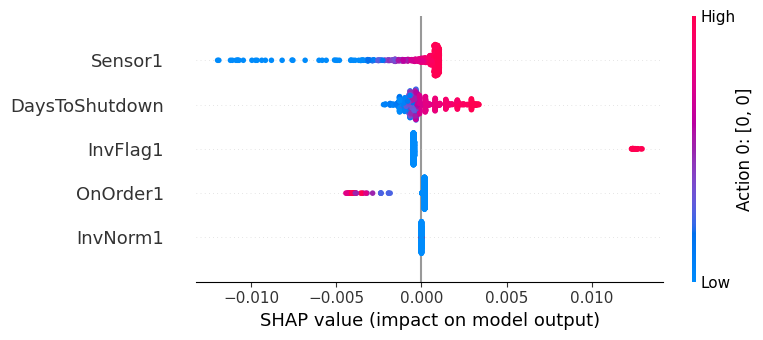

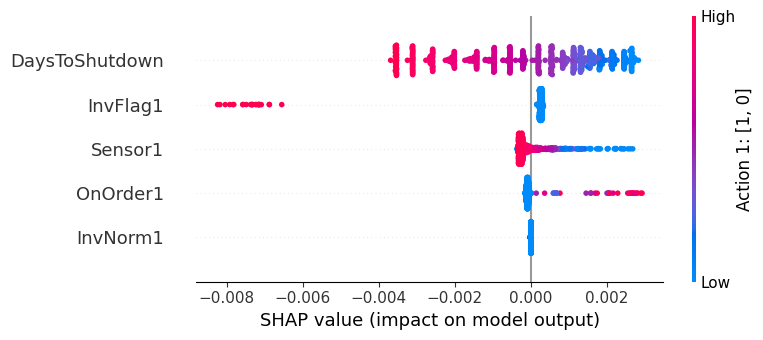

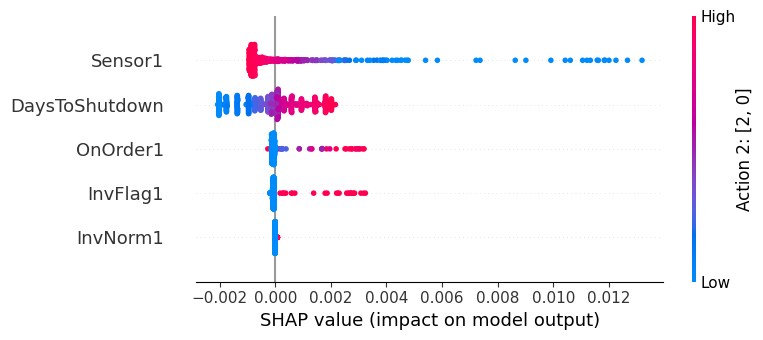

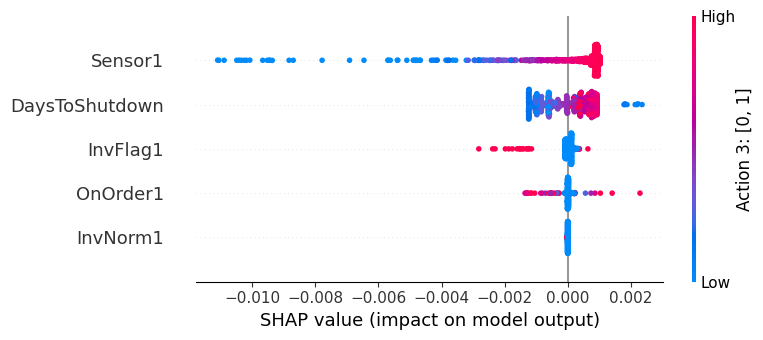

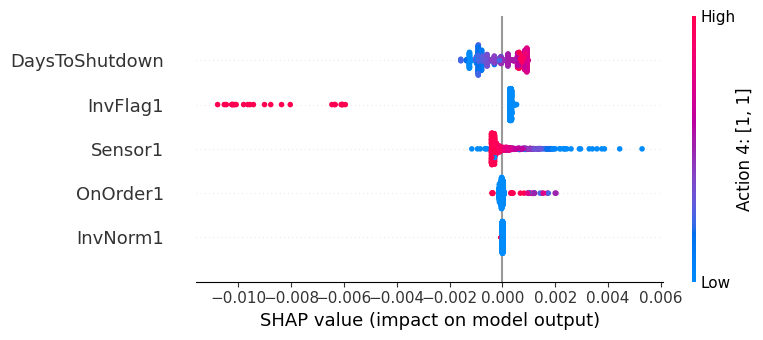

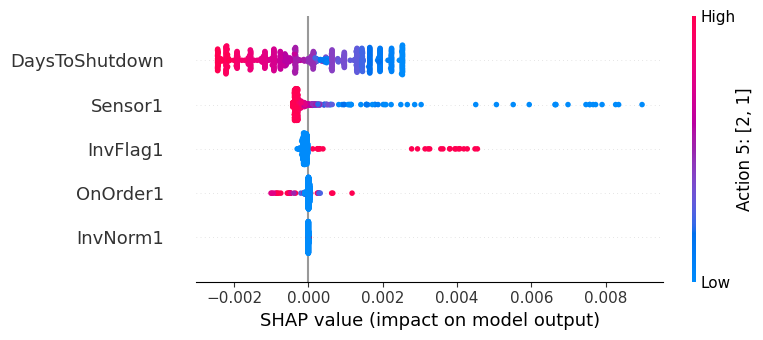

In [42]:
class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]

shap_values_ = np.array(shap_values)
for i in range(shap_values_.shape[0]):
  shap.summary_plot(shap_values[i], state_log_reshaped, color_bar_label='{}'.format(class_names[i]))



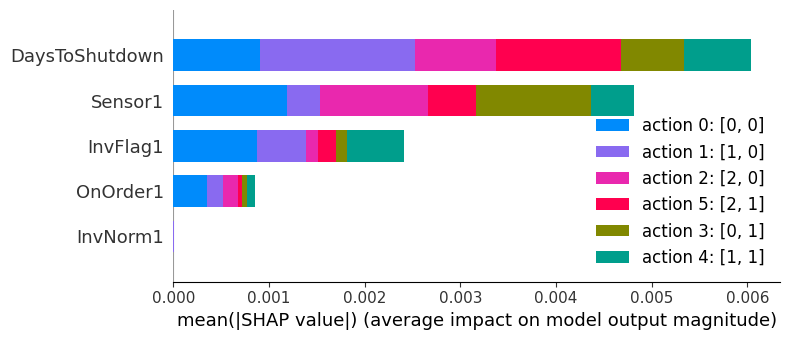

In [43]:
class_names = ["action 0: [0, 0]", "action 1: [1, 0]", "action 2: [2, 0]", "action 3: [0, 1]", "action 4: [1, 1]", "action 5: [2, 1]"]
shap.summary_plot(shap_values, feature_names=feature_names, class_names=class_names)


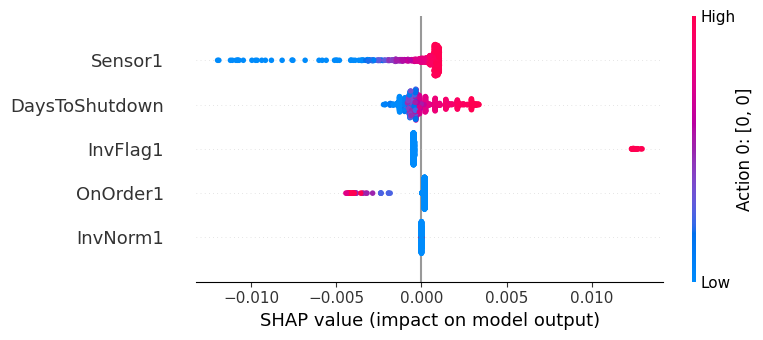

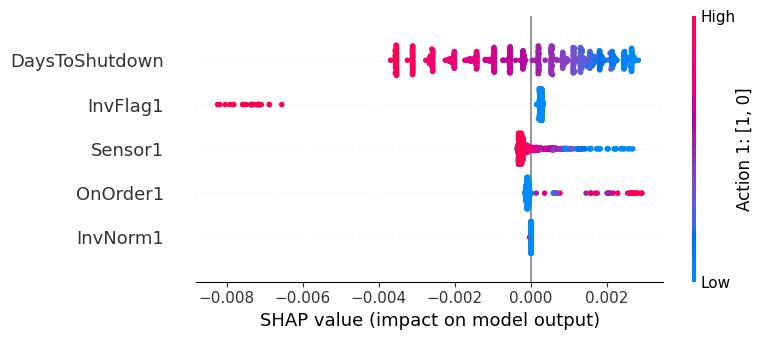

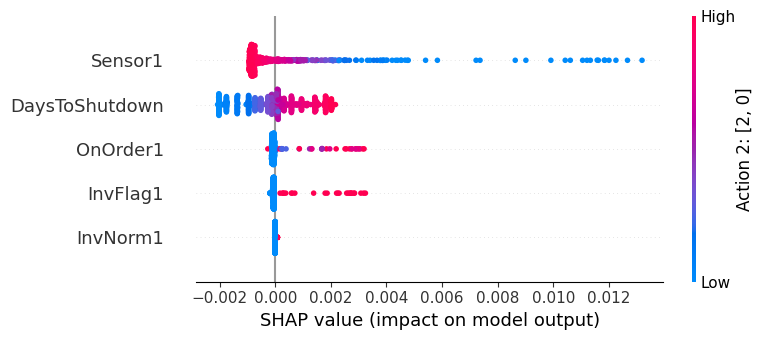

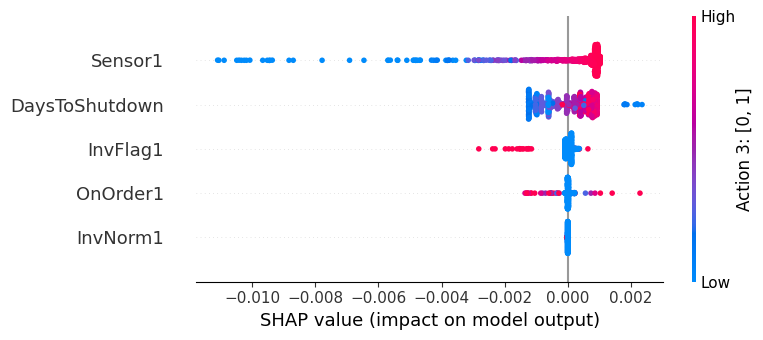

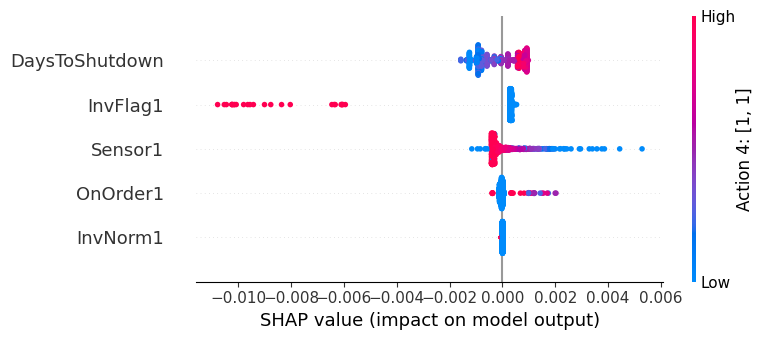

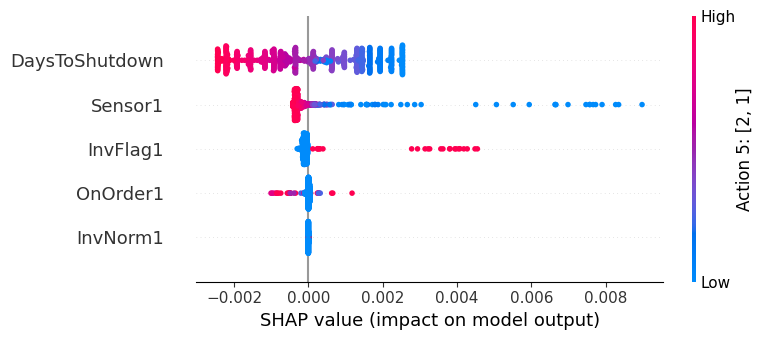

In [44]:
class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]

shap_values_ = np.array(shap_values)
for i in range(shap_values_.shape[0]):
  shap.summary_plot(shap_values[i], state_log_reshaped,  feature_names=feature_names, color_bar_label='{}'.format(class_names[i]))



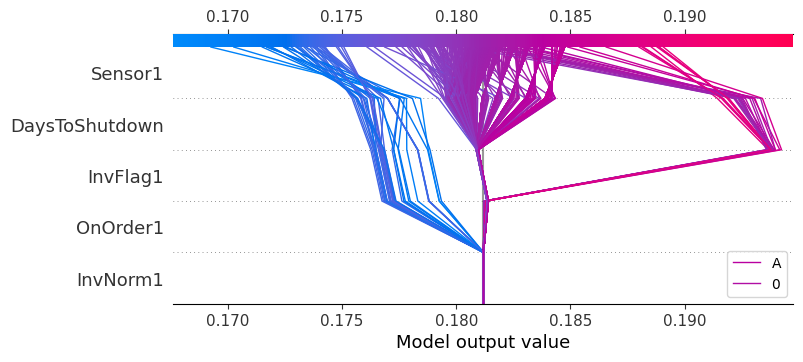

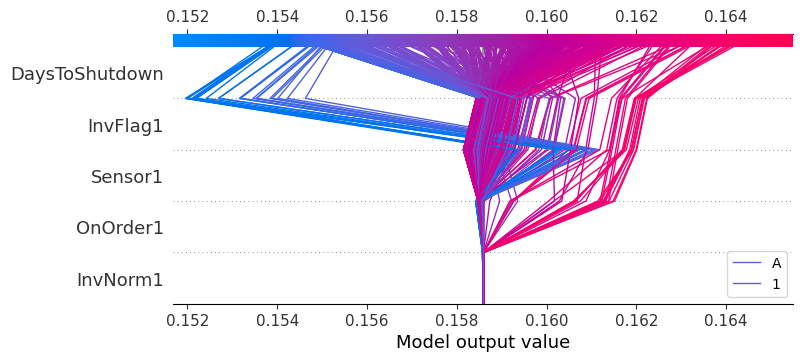

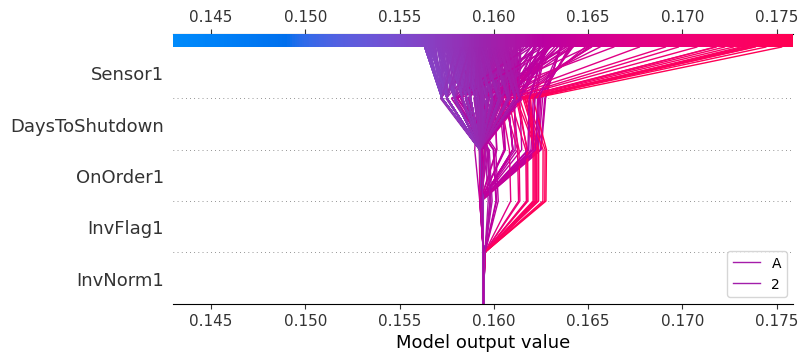

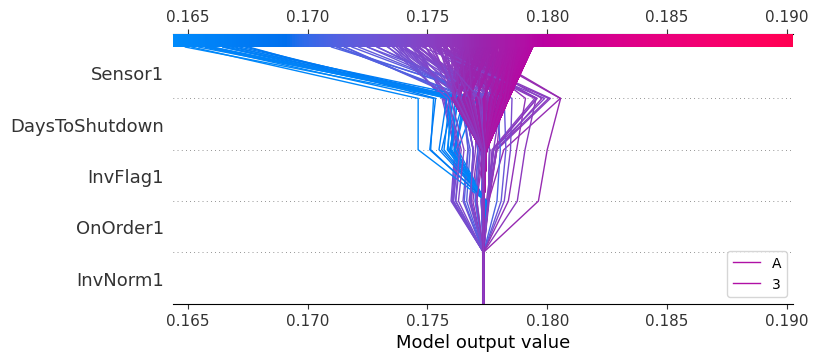

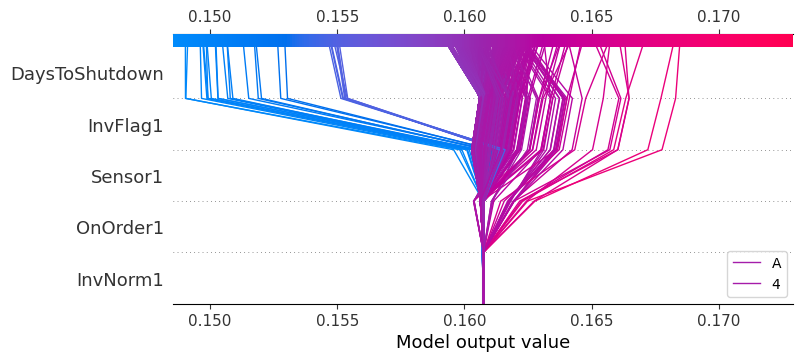

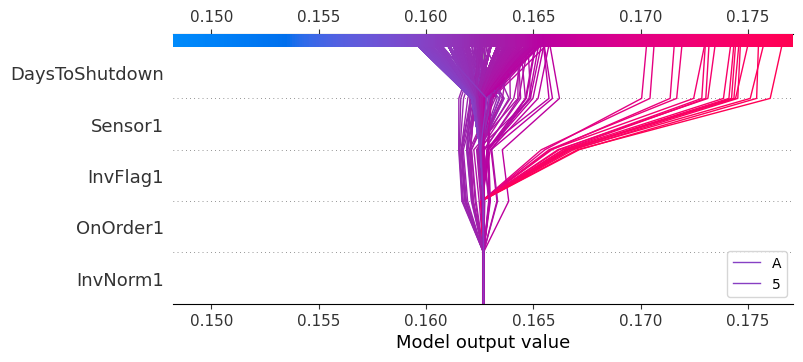

In [45]:
# class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]
class_names = ["A0", "A1", "A2", "A3", "A4", "A5"]

for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names, legend_labels=class_names[i], legend_location='lower right')


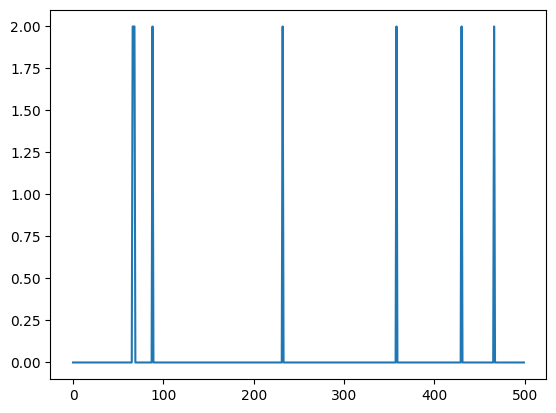

In [46]:
plt.plot(action_log[:,0])


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


(<Axes: ylabel='Observations'>,
 Text(0, 0.5, 'Observations'))

<Figure size 640x480 with 0 Axes>

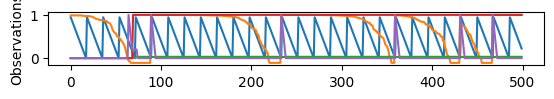

In [47]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Observations')

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [53]:
state_log_reshaped_min = state_log_reshaped.min()

In [54]:
state_log_reshaped_max = state_log_reshaped.max()
np.array(state_log_reshaped_max)
state_log_reshaped_max.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(5,)

In [55]:
state_log_l = state_log_reshaped
state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


DaysToShutdown   Sensor1  InvNorm1  InvFlag1  OnOrder1
0          0.839506  0.982615       0.0       0.0       0.0
1          0.787037  0.981676       0.0       0.0       0.0
2          0.734568  0.980358       0.0       0.0       0.0
3          0.682099  0.977741       0.0       0.0       0.0
4          0.629630  0.975936       0.0       0.0       0.0
..              ...       ...       ...       ...       ...
715        0.157407  0.868974       0.0       0.0       0.0
716        0.104938  0.838403       0.0       0.0       0.0
717        0.052469  0.837943       0.0       0.0       0.0
718        0.000000  0.837943       0.0       0.0       0.0
719        0.891975  0.817023       0.0       0.0       0.0

[720 rows x 5 columns]

## Make the function in a way that only gives 2 outputs of actions based on the observations and feed the shap plot with the MATLAB'S observation and action logs

In [56]:
# expected_value_reshaped = np.repeat(expected_value[:, np.newaxis], action_log[0].shape[0], axis=1)
# explainer.expected_value
# axs[1].scatter(range(0, len(action_log[0][:])), action_log[0][:], c=action_log[0][:]- explainer.expected_value, cmap = cmap, norm=norm)
# axs[1].set_ylabel('action')
# axs[1].yaxis.set_label_position('right')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [57]:
action_log_ = model_predict(observations)

In [58]:
action_log = model_predict(observations)
action_log.shape[0]

720

In [59]:
feature_names

['DaysToShutdown', 'Sensor1', 'InvNorm1', 'InvFlag1', 'OnOrder1']

In [60]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = (model_actorNet, model_criticNet) # define inputs and outputs of actor

    # explainer = shap.KernelExplainer(model_actorNet, state_log_l)
    # shap_values = explainer.shap_values(state_log_l) # Calculate shap values

    # explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
        # shap_values = explainer.shap_values(state_log_reshaped)
    state_log_re = state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,0], c=action_log[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,1], c=action_log[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,2], c=action_log[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,3], c=action_log[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,4], c=action_log[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,5], c=action_log[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re.OnOrder1, c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re.DaysToShutdown, c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re.Sensor1, c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re.InvNorm1, c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re.InvFlag1, c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')



    # if save_fig:
    #     fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')



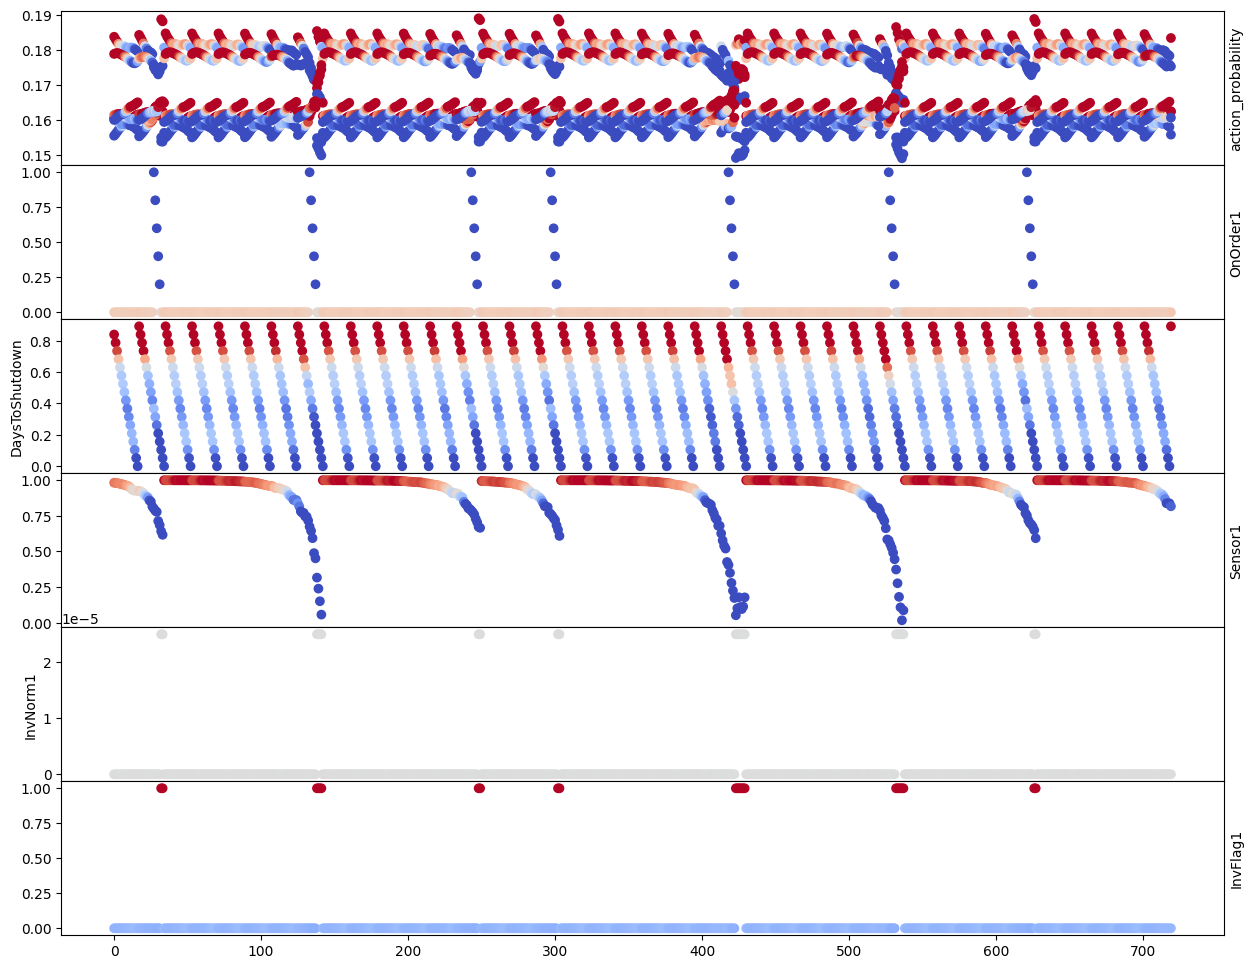

In [61]:
# output with shap values
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

In [101]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = (model_actorNet, model_criticNet) # define inputs and outputs of actor

    # explainer = shap.KernelExplainer(model_actorNet, state_log_l)
    # shap_values = explainer.shap_values(state_log_l) # Calculate shap values

    # explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
        # shap_values = explainer.shap_values(state_log_reshaped)
    actions = pd.read_csv('actions.csv')
    actions = np.array(actions)
    state_log_re = state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(7, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,0], c=action_log[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,1], c=action_log[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,2], c=action_log[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,3], c=action_log[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,4], c=action_log[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,5], c=action_log[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[1].set_ylabel('selected_actions')
    axs[1].yaxis.set_label_position('right')

    axs[2].scatter(range(0,len(shap_values[0][:,4])), state_log_re.OnOrder1, c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[4])

    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re.DaysToShutdown, c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[0])
    axs[3].yaxis.set_label_position('right')

    axs[4].scatter(range(0,len(shap_values[0][:,1])), state_log_re.Sensor1, c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[1])

    axs[5].scatter(range(0,len(shap_values[0][:,2])), state_log_re.InvNorm1, c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[2])
    axs[5].yaxis.set_label_position('right')

    axs[6].scatter(range(0,len(shap_values[0][:,3])), state_log_re.InvFlag1, c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[6].set_ylabel(feature_names[3])




    # if save_fig:
    #     fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')



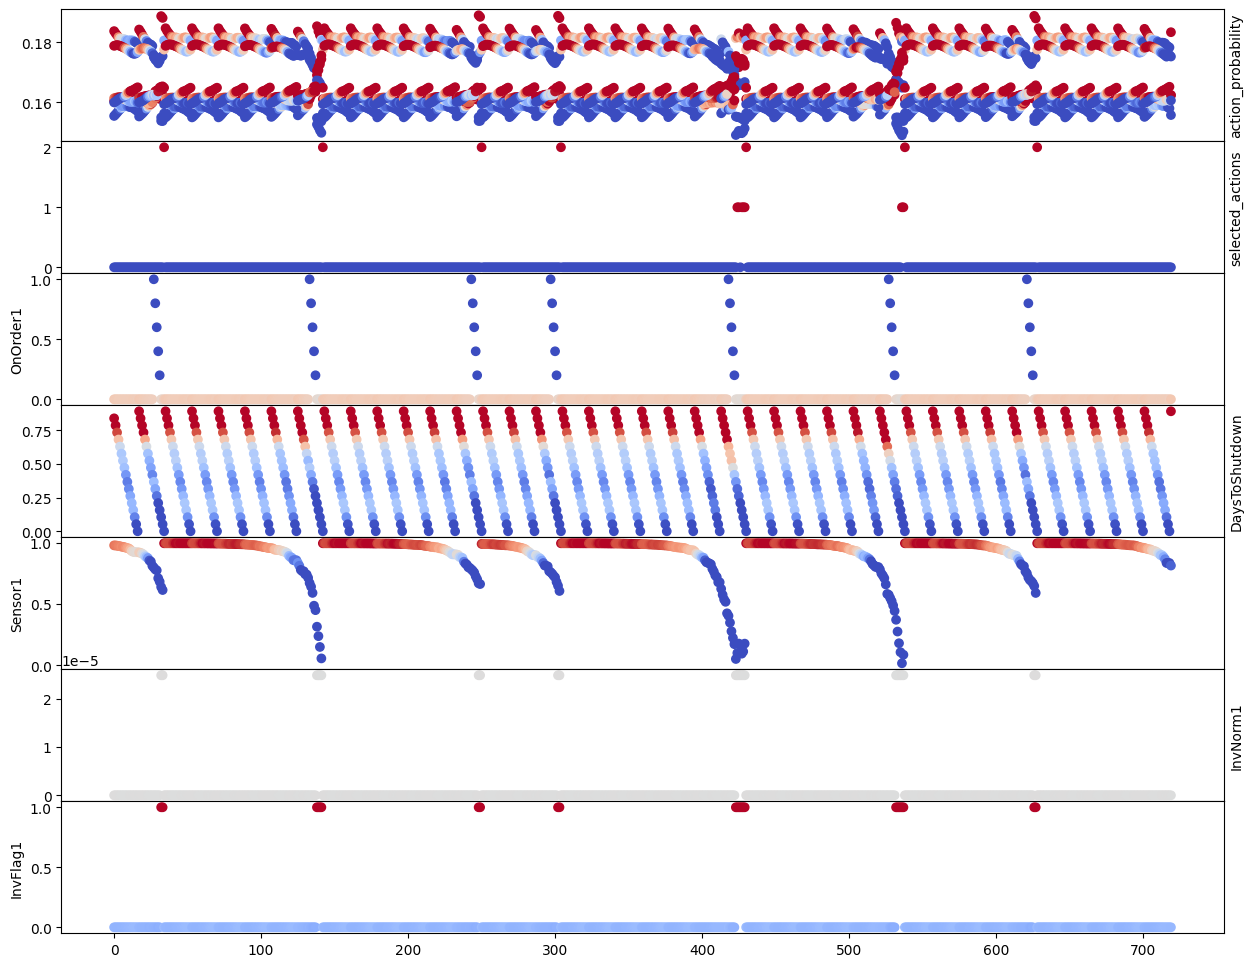

In [102]:
# output with shap values
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

# less data: slicing [0:300]

In [135]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    # Build explainer
    # model = (model_actorNet, model_criticNet) # define inputs and outputs of actor

    # explainer = shap.KernelExplainer(model_actorNet, state_log_l)
    # shap_values = explainer.shap_values(state_log_l) # Calculate shap values

    # explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
        # shap_values = explainer.shap_values(state_log_reshaped)
    actions = pd.read_csv('actions.csv')
    actions = np.array(actions)
    actions = actions[0:300]
    state_log_l_ = state_log_l[0:300]
    state_log_re = state_log_l_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(7, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_log[0:300].shape[0]), action_log[0:300,0], c=action_log[0:300,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log[0:300].shape[0]), action_log[0:300,1], c=action_log[0:300,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log[0:300].shape[0]), action_log[0:300,2], c=action_log[0:300,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log[0:300].shape[0]), action_log[0:300,3], c=action_log[0:300,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log[0:300].shape[0]), action_log[0:300,4], c=action_log[0:300,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log[0:300].shape[0]), action_log[0:300,5], c=action_log[0:300,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0, actions.shape[0]), actions[0:300,0], c=actions[0:300,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[1].set_ylabel('selected_actions')
    axs[1].yaxis.set_label_position('right')

    axs[2].scatter(range(0,len(shap_values[0][0:300,4])), state_log_re.OnOrder1, c=shap_values[0][0:300,4], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[4])

    axs[3].scatter(range(0,len(shap_values[0][0:300,0])), state_log_re.DaysToShutdown, c=shap_values[0][0:300,0], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[0])
    axs[3].yaxis.set_label_position('right')

    axs[4].scatter(range(0,len(shap_values[0][0:300,1])), state_log_re.Sensor1, c=shap_values[0][0:300,1], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[1])

    axs[5].scatter(range(0,len(shap_values[0][0:300,2])), state_log_re.InvNorm1, c=shap_values[0][0:300,2], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[2])
    axs[5].yaxis.set_label_position('right')

    axs[6].scatter(range(0,len(shap_values[0][0:300,3])), state_log_re.InvFlag1, c=shap_values[0][0:300,3], cmap=cmap, norm=norm)
    axs[6].set_ylabel(feature_names[3])




    # if save_fig:
    #     fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


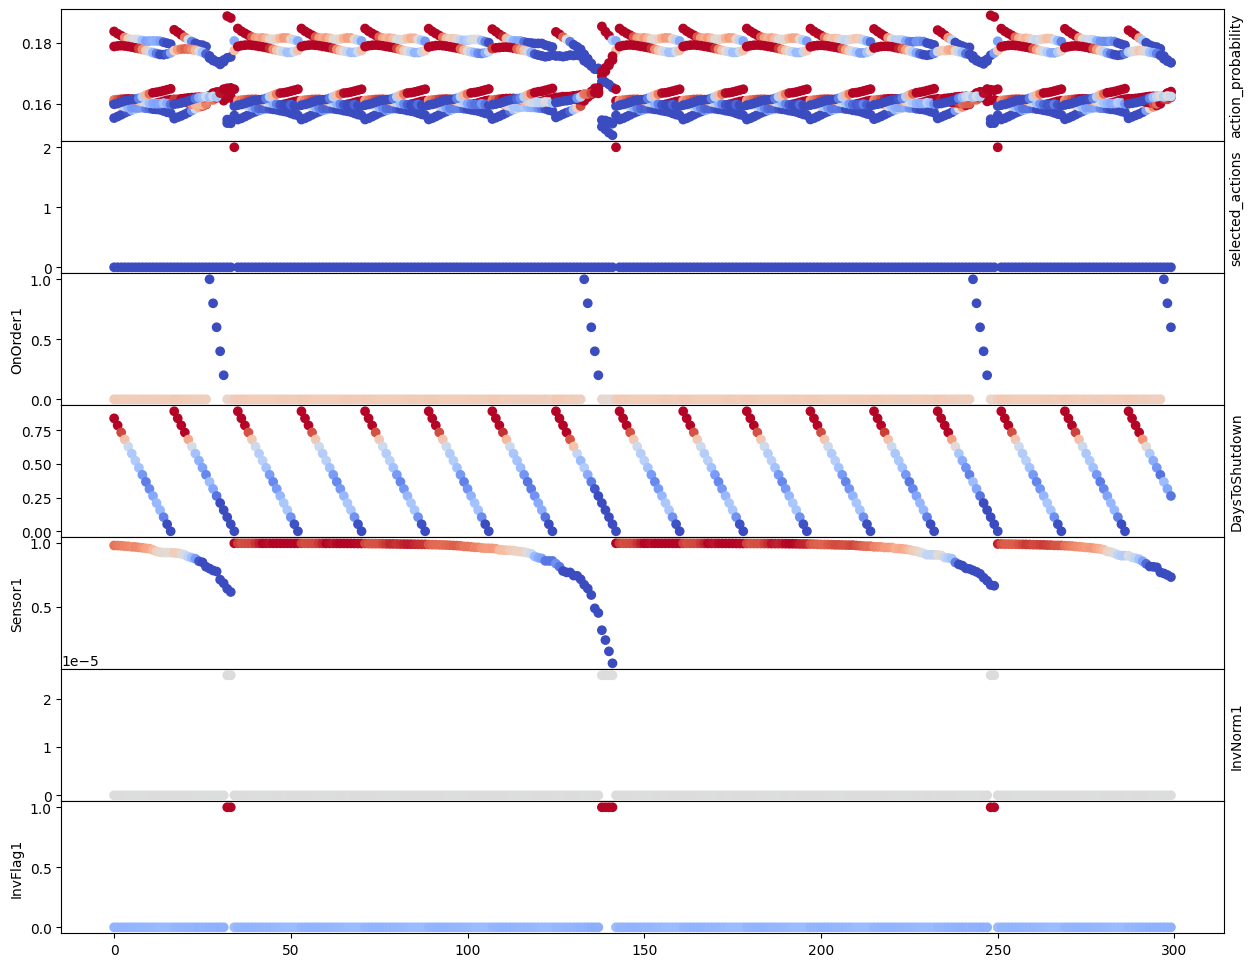

In [136]:
# output with shap values
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

In [91]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):


    state_log_re = state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, selected_act_.shape[0]), selected_act_[:,0], c= selected_act_[:,0], cmap = cmap, norm=norm)
    axs[0].scatter(range(0, selected_act_.shape[0]), selected_act_[:,1], c= selected_act_[:,1], cmap = cmap, norm=norm)
    # axs[0].plot(selected_act_)
    # axs[0].plot(selected_act_[:,1])
    axs[0].set_ylabel('action')
    axs[0].yaxis.set_label_position('right')
    axs[0].yaxis.set_label_position('right')
    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re.OnOrder1, c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re.DaysToShutdown, c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re.Sensor1, c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re.InvNorm1, c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re.InvFlag1, c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')



    # if save_fig:
    #     fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')



`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


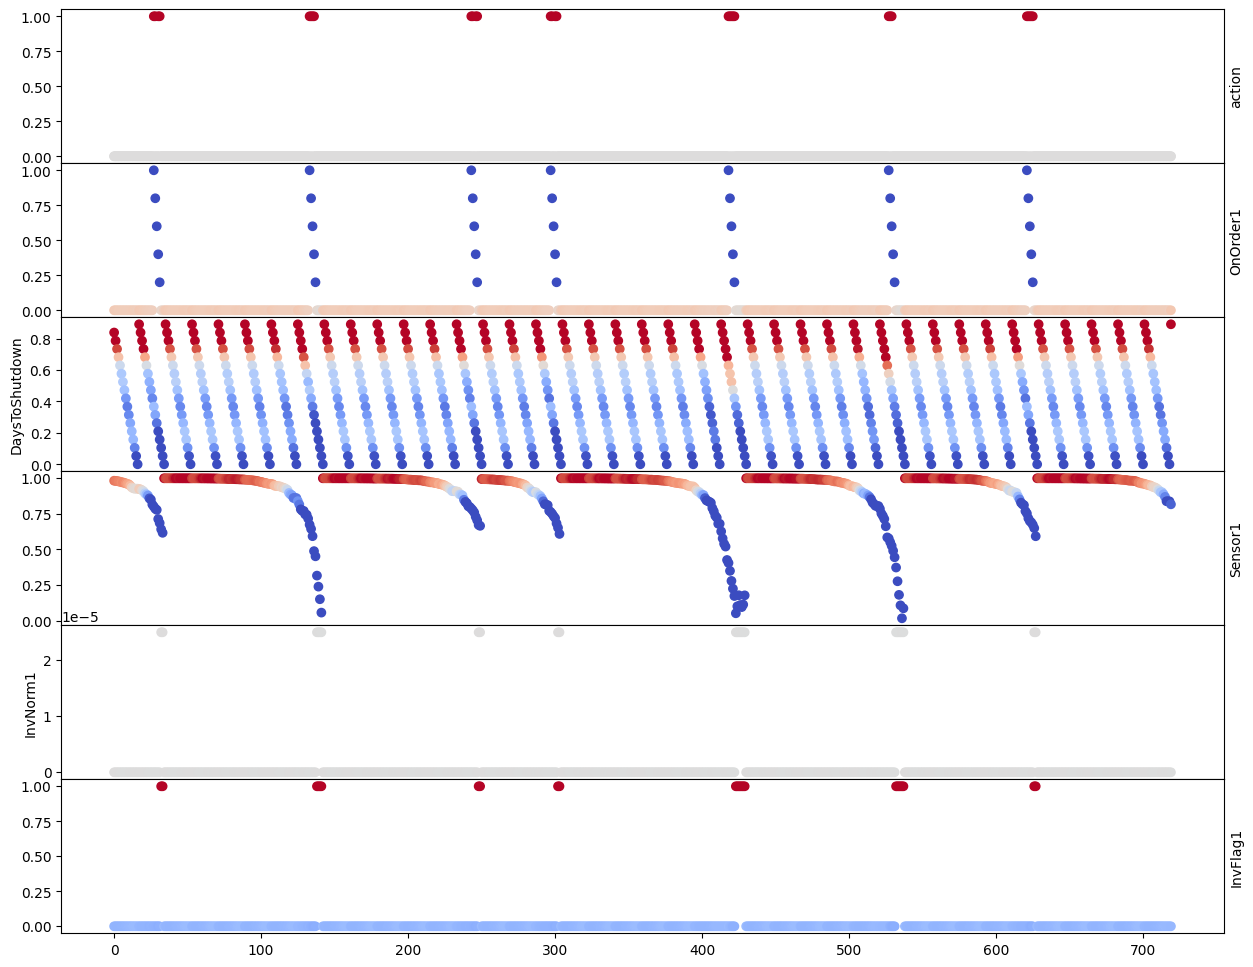

In [92]:
# output with shap values
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

In [89]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):


    state_log_re = state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, selected_act_.shape[0]), selected_act_[:,0], c= selected_act_[:,0], cmap = cmap, norm=norm)
    axs[0].scatter(range(0, selected_act_.shape[0]), selected_act_[:,1], c= selected_act_[:,1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('actions')
    axs[0].yaxis.set_label_position('right')
    axs[0].yaxis.set_label_position('right')
    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re.OnOrder1, c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re.DaysToShutdown, c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re.Sensor1, c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re.InvNorm1, c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re.InvFlag1, c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')



    # if save_fig:
    #     fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')



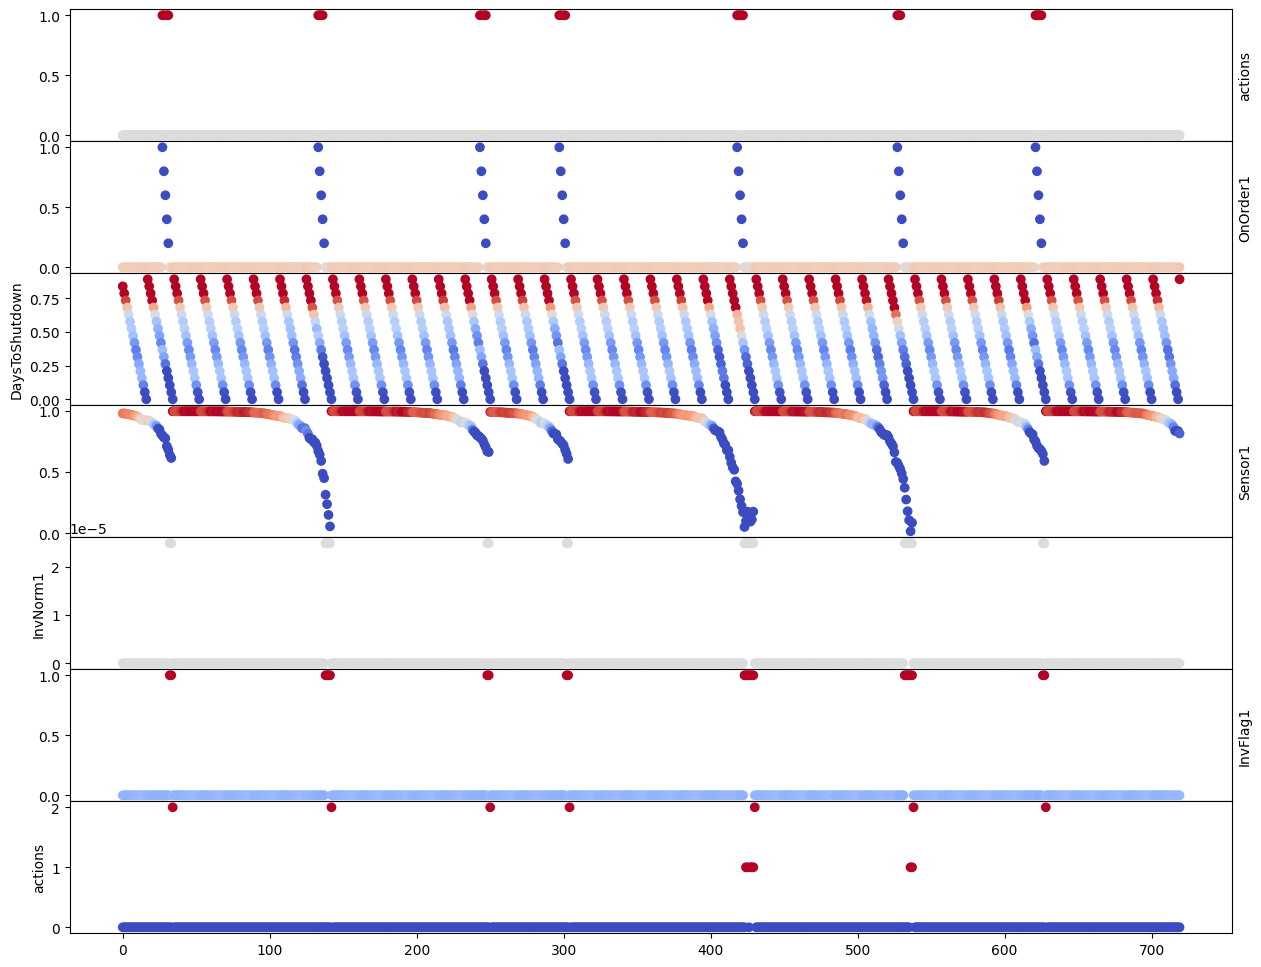

In [90]:
# output with shap values
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

# MATLAB's Results

In [66]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    actions = pd.read_csv('actions.csv')
    actions = np.array(actions)

    state_log_re = state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    norm_ = plt.Normalize(vmin=0, vmax=2) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('actions')
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re.OnOrder1, c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[1].plot(state_log_re.OnOrder1)
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re.DaysToShutdown, c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[2].plot(state_log_re.DaysToShutdown)

    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re.Sensor1, c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[3].plot(state_log_re.Sensor1)

    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re.InvNorm1, c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[4].plot(state_log_re.InvNorm1)

    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re.InvFlag1, c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')



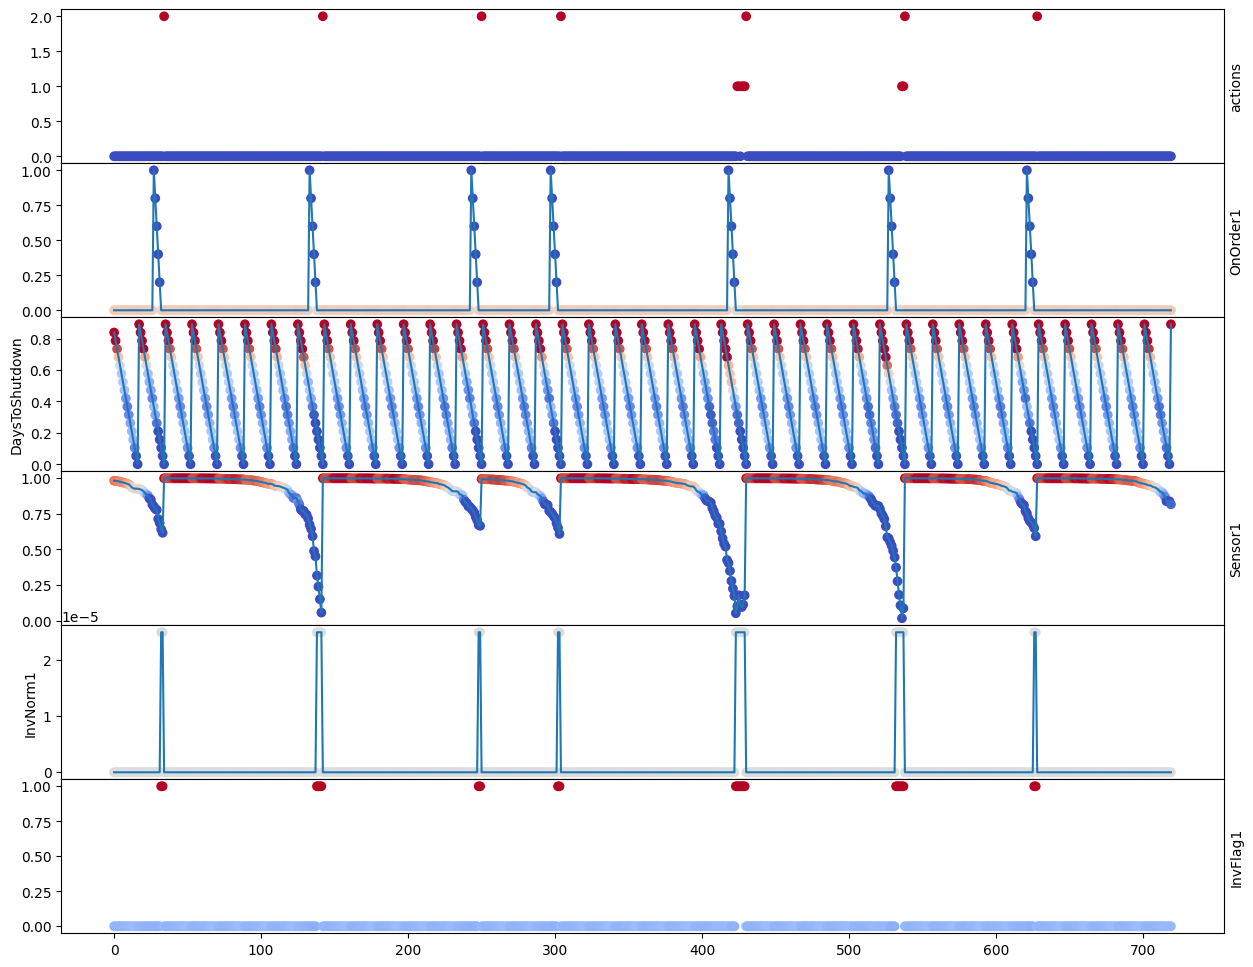

In [67]:
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

In [83]:
def explain(actor = model_actorNet, critic = model_criticNet, state_log_=state_log_l, feature_names=feature_names, action_log_=action_log_, cmap='coolwarm', save_fig=False):

    act_prob = pd.read_csv('actions_prob.csv')
    act_prob = np.array(act_prob)
    action_log = act_prob
    max_indices = np.argmax(action_log, axis=1)
    actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])
    selected_act = []
    selected_act_ = actionelements[max_indices]


    state_log_re = state_log_l*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    norm_ = plt.Normalize(vmin=0, vmax=2) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,0], c=action_log[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,1], c=action_log[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,2], c=action_log[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob')
    axs[0].yaxis.set_label_position('right')
    # axs[0].scatter(range(0, action_log.shape[0]), action_log[:,3], c=action_log[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob')
    axs[0].yaxis.set_label_position('right')
    # axs[0].scatter(range(0, action_log.shape[0]), action_log[:,4], c=action_log[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob')
    axs[0].yaxis.set_label_position('right')
    # axs[0].scatter(range(0, action_log.shape[0]), action_log[:,5], c=action_log[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_prob')
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re.OnOrder1, c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[1].plot(state_log_re.OnOrder1)
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re.DaysToShutdown, c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[2].plot(state_log_re.DaysToShutdown)

    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re.Sensor1, c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[3].plot(state_log_re.Sensor1)

    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re.InvNorm1, c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[4].plot(state_log_re.InvNorm1)

    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re.InvFlag1, c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')

    axs[5].scatter(range(0, selected_act_.shape[0]), selected_act_[:,0], c= selected_act_[:,0], cmap = cmap, norm=norm_)
    axs[5].scatter(range(0, selected_act_.shape[0]), selected_act_[:,1], c= selected_act_[:,1], cmap = cmap, norm=norm_)
    # axs[5].plot(selected_act_[:,0])
    # axs[5].plot(selected_act_[:,1])
    axs[5].set_ylabel('action')
    axs[5].yaxis.set_label_position('right')


    # if save_fig:
    #     fig.savefig("Shap_RL_Example.pdf", bbox_inches='tight')



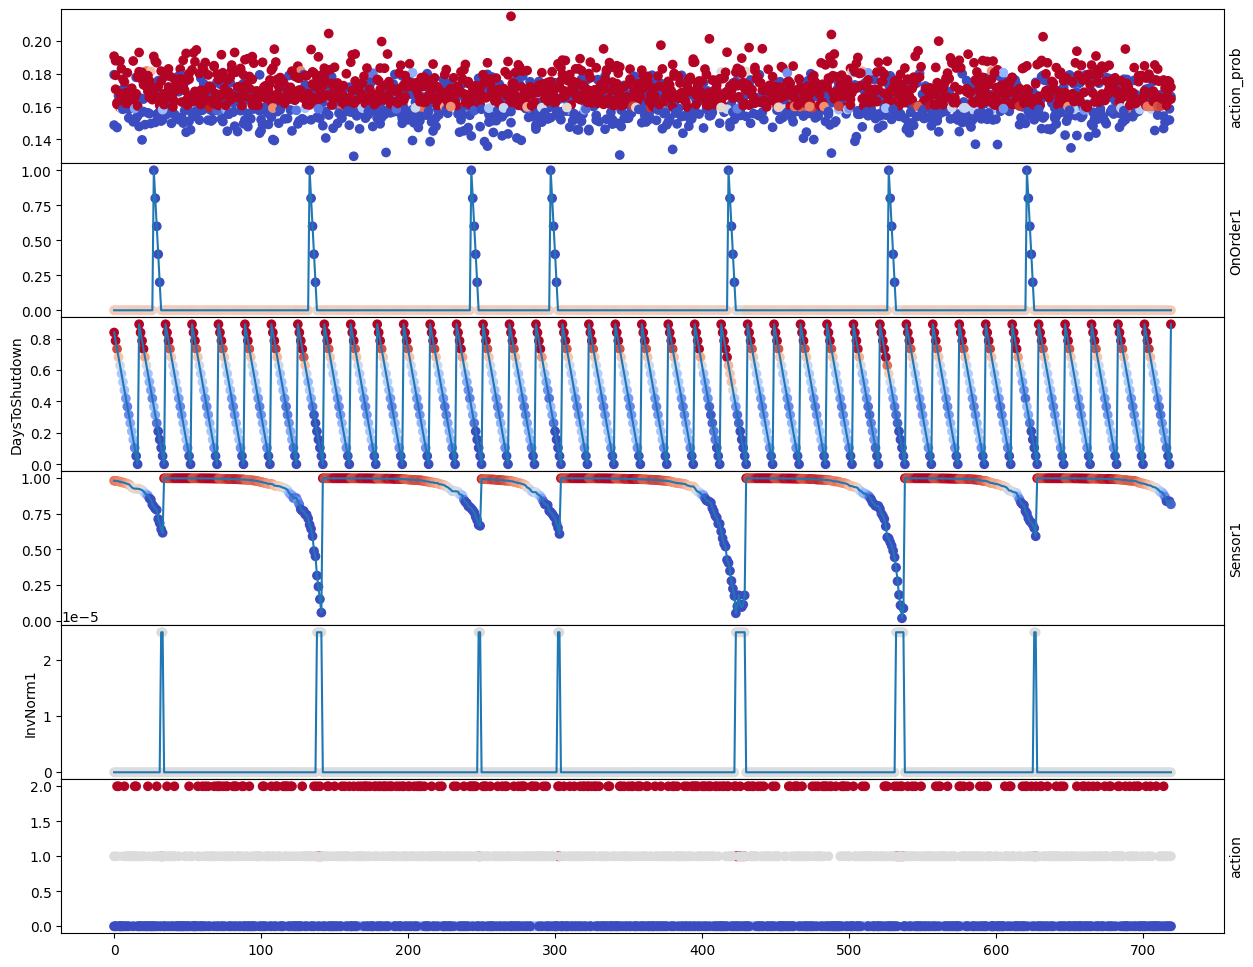

In [84]:
explain(model_actorNet, model_criticNet, state_log_l, feature_names, action_log_)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


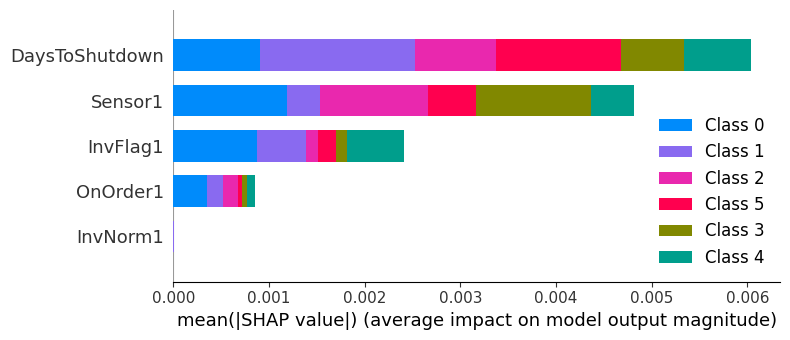

In [70]:
shap.summary_plot(shap_values, feature_names=feature_names)

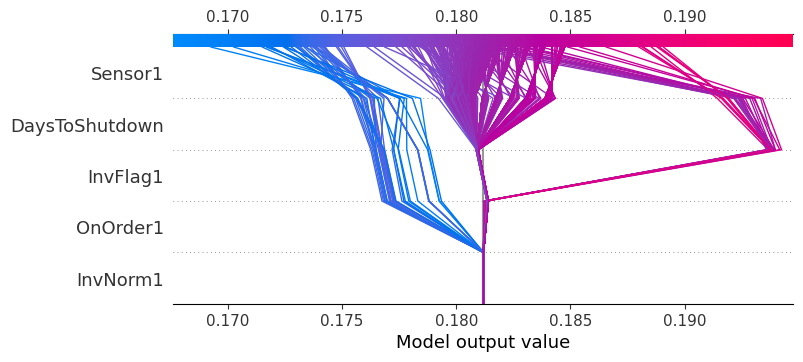

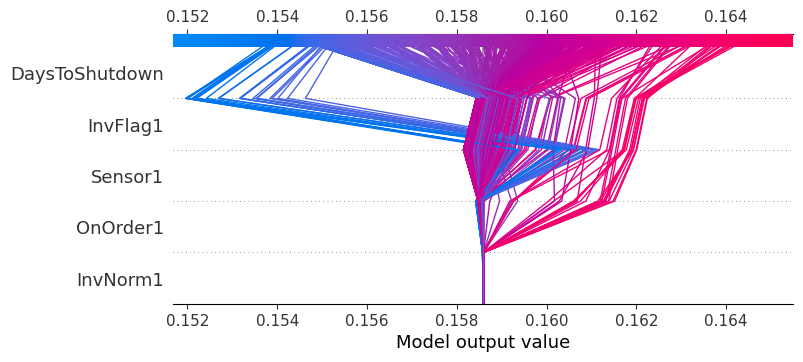

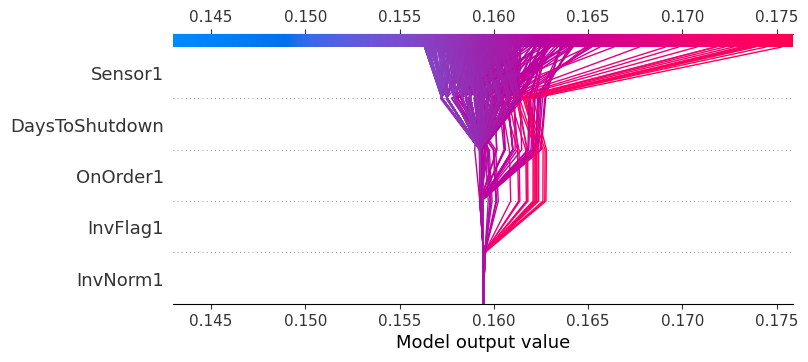

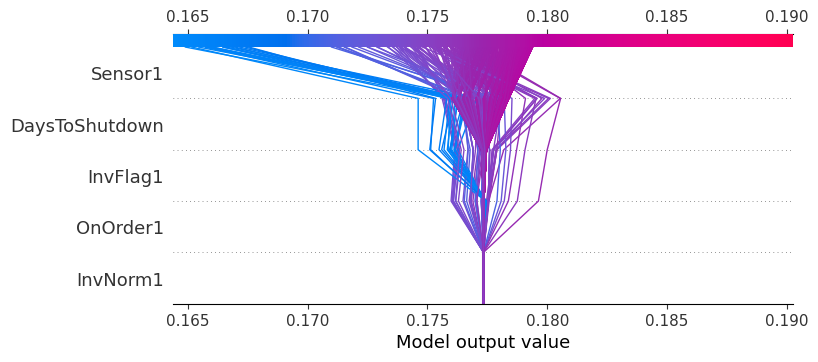

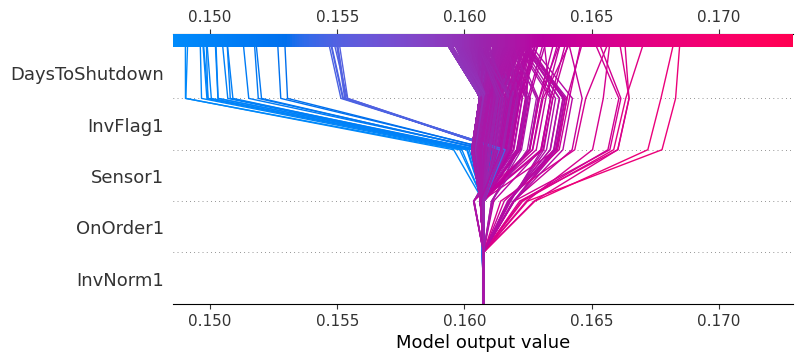

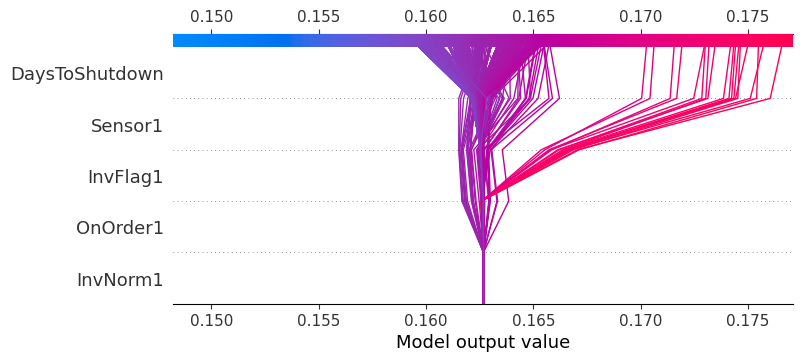

In [71]:
for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names)


In [72]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [73]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [74]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [75]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [76]:
shap_values_ = np.array(shap_values)
print(shap_values_.shape)
shap_values_ = np.array(shap_values[1])
print(shap_values_.shape)


(6, 720, 5)
(720, 5)


In [77]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [78]:
explainer_critic = shap.KernelExplainer(model_criticNet, state_log_)
shap_values_critic = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/500 [00:00<?, ?it/s]

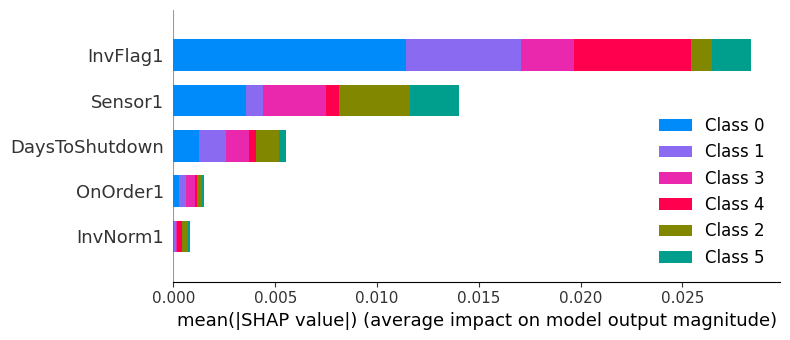

In [79]:
shap.summary_plot(shap_values_critic, feature_names=feature_names)

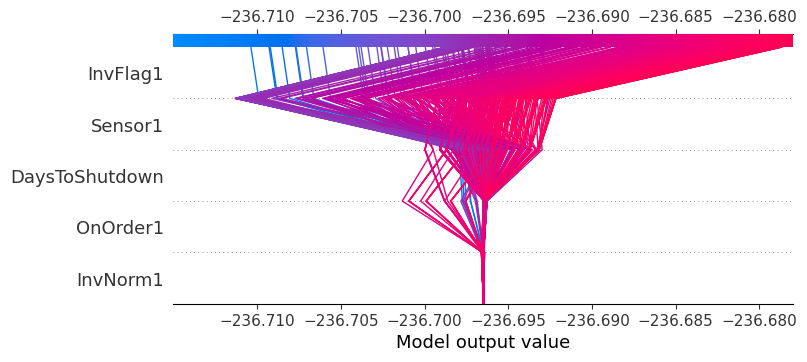

In [80]:
shap.decision_plot(explainer_critic.expected_value[0], shap_values_critic[0], feature_names=feature_names)


